In [23]:
import os
import sys
sys.path.append('../Prelim_Stats')
import config
import numpy as np
import xarray as xr
import pyproj
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.stats import probplot
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import multivariate_normal
from pyproj import Transformer
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline
import pyproj
from pyextremes import get_extremes, get_return_periods
from pyextremes.plotting import plot_extremes
from closest_grid_cell import select_nearest_grid_cell
from pyextremes import EVA
import xarray as xr
import matplotlib.pyplot as plt

For LR grid

In [24]:
regions_sourcefile= xr.open_dataset("regions_CH2018_all_EUR-11.nc")

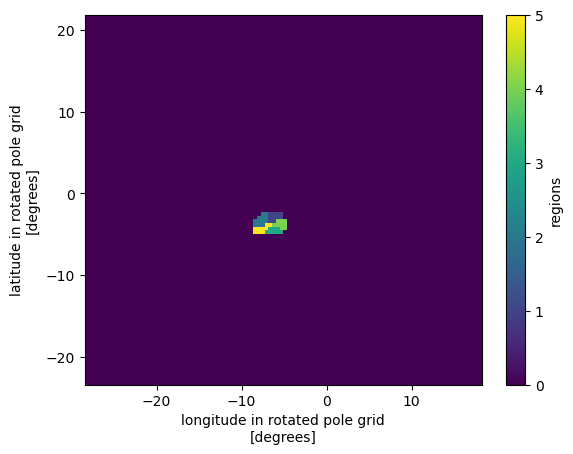

In [25]:
regions_sourcefile["regions"]. plot()

In [26]:
# Create mask with original region values, others set to nan
region_values = regions_sourcefile["regions"].values
mask = np.where(np.isin(region_values, [1, 2, 3, 4, 5]), region_values, np.nan)



In [27]:
rotated_pole = regions_sourcefile["rotated_pole"]
pole_lon = rotated_pole.grid_north_pole_longitude
pole_lat = rotated_pole.grid_north_pole_latitude

In [28]:
rlon = regions_sourcefile['rlon'].values
rlat = regions_sourcefile['rlat'].values
rlon_2d, rlat_2d = np.meshgrid(rlon, rlat)

rot_pole = ccrs.RotatedPole(pole_longitude=pole_lon, pole_latitude=pole_lat)

pc = ccrs.PlateCarree()
lon_2d, lat_2d = pc.transform_points(rot_pole, rlon_2d, rlat_2d)[..., :2].T

In [30]:
target_coarse_ds = xr.open_dataset(f"{config.DATASETS_TRAINING_DIR}/TabsD_step2_coarse.nc")

In [32]:
target_lat_coarse = target_coarse_ds['lat'].values
target_lon_coarse = target_coarse_ds['lon'].values

In [33]:
# Create mask with original region values, others set to nan
region_values = regions_sourcefile["regions"].values
mask = np.where(np.isin(region_values, [1, 2, 3, 4, 5]), region_values, np.nan)

# Build mask DataArray with coordinates
mask_da = xr.DataArray(
    mask,
    dims=("rlat", "rlon"),
    coords={
        "rlat": ("rlat", rlat),
        "rlon": ("rlon", rlon),
        "lat": (("rlat", "rlon"), lat_2d.T),
        "lon": (("rlat", "rlon"), lon_2d.T)
    },
    name="swiss_mask"
)

# Transfer mask to Swiss lat/lon domain
lat_1d = target_lat_coarse[:, 0]
lon_1d = target_lon_coarse[0, :]
target_lon_2d, target_lat_2d = np.meshgrid(lon_1d, lat_1d)
target_points = np.column_stack([target_lat_2d.ravel(), target_lon_2d.ravel()])

mask_lat = mask_da["lat"].values.flatten()
mask_lon = mask_da["lon"].values.flatten()
mask_flat = mask_da.values.flatten()

from scipy.spatial import cKDTree
tree = cKDTree(np.column_stack([mask_lat, mask_lon]))
_, idx = tree.query(target_points)
mask_on_swiss_grid = mask_flat[idx].reshape(target_lat_2d.shape)

mask_on_swiss_grid = xr.DataArray(
    mask_on_swiss_grid,
    dims=("lat", "lon"),
    coords={
        "lat": lat_1d,
        "lon": lon_1d
    },
    name="swiss_mask_on_coarse_grid"
)

mask_on_swiss_grid.to_netcdf("swiss_mask_on_coarse_grid.nc")

For HR grid

In [35]:
target_ds = xr.open_dataset(f"{config.TARGET_DIR}/TabsD_1971_2023.nc").isel(time=0)
target_lat = target_ds['lat'].values
target_lon = target_ds['lon'].values

In [36]:
target_lat = target_ds['lat'].values
target_lon = target_ds['lon'].values

In [37]:
region_values = regions_sourcefile["regions"].values
mask = np.where(np.isin(region_values, [1, 2, 3, 4, 5]), region_values, np.nan)

mask_da = xr.DataArray(
    mask,
    dims=("rlat", "rlon"),
    coords={
        "rlat": ("rlat", rlat),
        "rlon": ("rlon", rlon),
        "lat": (("rlat", "rlon"), lat_2d.T),
        "lon": (("rlat", "rlon"), lon_2d.T)
    },
    name="swiss_mask"
)

lat_1d = target_lat[:, 0]
lon_1d = target_lon[0, :]
target_lon_2d, target_lat_2d = np.meshgrid(lon_1d, lat_1d)
target_points = np.column_stack([target_lat_2d.ravel(), target_lon_2d.ravel()])

mask_lat = mask_da["lat"].values.flatten()
mask_lon = mask_da["lon"].values.flatten()
mask_flat = mask_da.values.flatten()

from scipy.spatial import cKDTree
tree = cKDTree(np.column_stack([mask_lat, mask_lon]))
_, idx = tree.query(target_points)
mask_on_swiss_grid = mask_flat[idx].reshape(target_lat_2d.shape)

mask_on_swiss_grid = xr.DataArray(
    mask_on_swiss_grid,
    dims=("lat", "lon"),
    coords={
        "lat": lat_1d,
        "lon": lon_1d
    },
    name="swiss_mask_on_hr_grid"
)

mask_on_swiss_grid.to_netcdf("swiss_mask_on_hr_grid.nc")